**Autoreload external references**

In [1]:
%load_ext autoreload
%autoreload 2

**Import of data wrangling functions**

In [2]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd() / "src"))

import data_wrangling as dw

**Librerías utilizadas**

In [3]:
import pandas as pd

**Limpieza de datos**

In [4]:
clients_groups = dw.clients_groups_file()
clients_demo = dw.clients_demo_file()
testing_results = dw.testing_results_file()

---

**Análisis de datos** 
*- Clientes* 

General Client Profile Metrics
       clnt_age  clnt_tenure_yr          bal
count  50500.00        50500.00     50500.00
mean      47.32           12.03    149494.77
std       15.52            6.86    302003.29
min       17.00            2.00     23789.44
25%       33.50            6.00     39881.04
50%       48.00           11.00     65733.60
75%       59.50           16.00    139938.95
max       96.00           55.00  16320040.15


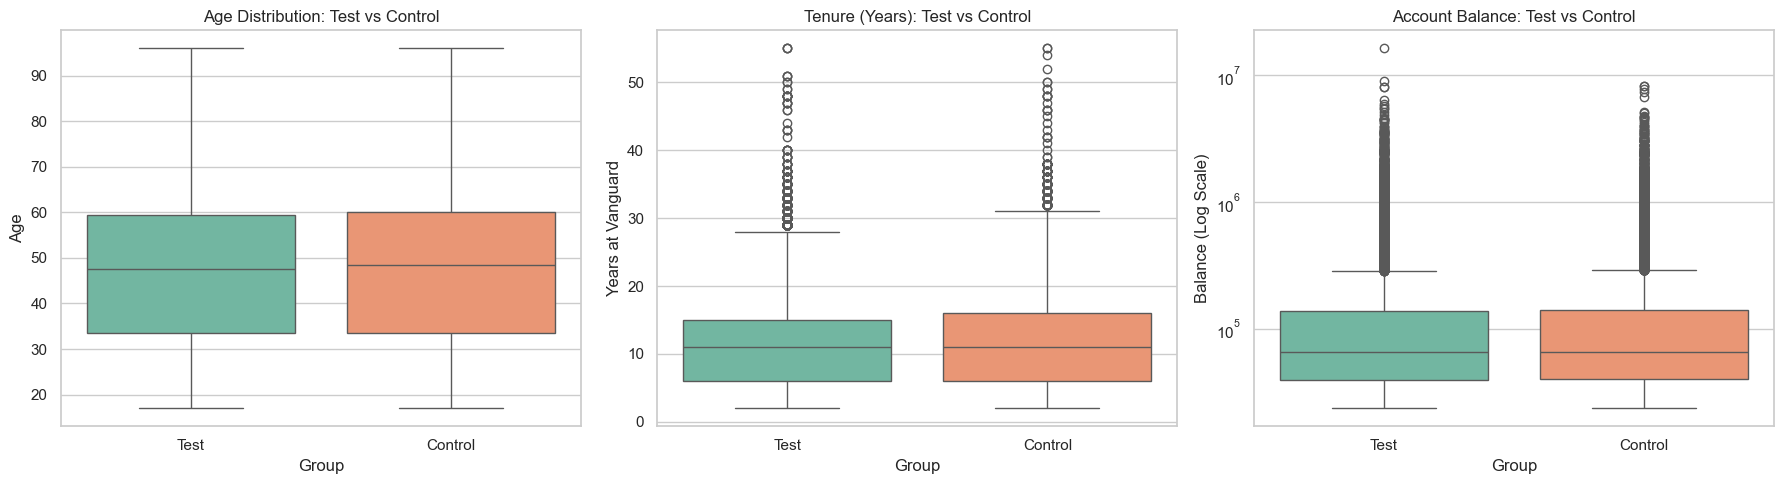


 Gender Distribution per Group:
gendr         F     M     U  X
Variation                     
Control    7543  7970  8019  0
Test       8716  8977  9273  2


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

# 1. Ignore FutureWarnings to keep the notebook clean
warnings.filterwarnings('ignore', category=FutureWarning)

# 2. General Descriptive Statistics
# Who are our primary clients?
print("General Client Profile Metrics")
stats = clients_demo[['clnt_age', 'clnt_tenure_yr', 'bal']].describe().round(2)
print(stats)

# 3. Visual Analysis: Test vs Control Balance
# Setting the visual style for the report
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot A: Age Distribution (Corrected with hue and legend=False)
sns.boxplot(ax=axes[0], x='Variation', y='clnt_age', data=clients_demo, 
            hue='Variation', palette="Set2", legend=False)
axes[0].set_title('Age Distribution: Test vs Control')
axes[0].set_xlabel('Group')
axes[0].set_ylabel('Age')

# Plot B: Tenure Distribution
sns.boxplot(ax=axes[1], x='Variation', y='clnt_tenure_yr', data=clients_demo, 
            hue='Variation', palette="Set2", legend=False)
axes[1].set_title('Tenure (Years): Test vs Control')
axes[1].set_xlabel('Group')
axes[1].set_ylabel('Years at Vanguard')

# Plot C: Balance Distribution (Log Scale, used for financial data outliers)
sns.boxplot(ax=axes[2], x='Variation', y='bal', data=clients_demo, 
            hue='Variation', palette="Set2", legend=False)
axes[2].set_title('Account Balance: Test vs Control')
axes[2].set_yscale('log') 
axes[2].set_xlabel('Group')
axes[2].set_ylabel('Balance (Log Scale)')

plt.tight_layout()
plt.show()

# 4. Gender Balance Check
print("\n Gender Distribution per Group:")
gender_dist = clients_demo.groupby(['Variation', 'gendr']).size().unstack(fill_value=0)
print(gender_dist)

1. Validación del Experimento (Gráficos de Caja)

    Las cajas de Test y Control son prácticamente idénticas en altura y tamaño para Edad, Antigüedad y Balance.
- Significado: la aleatorización fue exitosa. No hay un sesgo donde, por ejemplo, los más jóvenes hayan caído en un grupo y los mayores en otro.
- Balance Financiero: la mayoría de los clientes tienen saldos similares, a pesar de esos puntos superiores (clientes con saldos muy altos).

2. Perfil del Cliente Primario (Estadísticas)
El cliente típico de Vanguard en este experimento:
Tiene una media de edad de 47 años (es un público maduro, no centennials).
Lleva unos 12 años con la empresa (son clientes leales, no nuevos usuarios).
Tiene un balance promedio de $149,494 (manejan carteras de inversión considerables).

3. Distribución de Género
Los grupos están equilibrados. Aunque el grupo Test tiene más personas en números absolutos (aprox. 26k vs 23k), la proporción entre Femenino (F), Masculino (M) y Desconocido (U) se mantiene constante.

**Análisis de datos**
*-Reacción de clientes*

TASA DE FINALIZACIÓN POR GRUPO:
Variation
Control    65.59%
Test       69.29%
Name: client_id, dtype: object


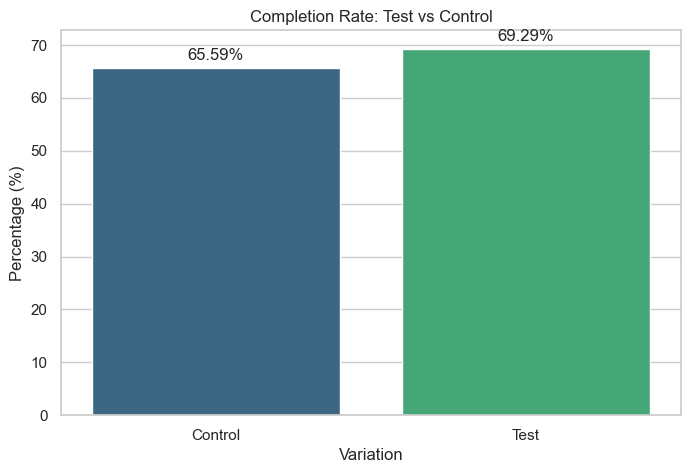

In [6]:
# KPI 1: Completion Rate Analysis

# 1. Total unique clients per variation
total_clients = testing_results.groupby('Variation')['client_id'].nunique()

# 2. Unique clients who reached the 'confirm' step
confirmed_clients = testing_results[testing_results['process_step'] == 'confirm'].groupby('Variation')['client_id'].nunique()

# 3. Calculation of the rate
completion_rate = (confirmed_clients / total_clients) * 100

print("TASA DE FINALIZACIÓN POR GRUPO:")
print(completion_rate.round(2).astype(str) + '%')

# 4. Visualization of the Success
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=completion_rate.index, y=completion_rate.values, hue=completion_rate.index, palette='viridis', legend=False)
plt.title('Completion Rate: Test vs Control')
plt.ylabel('Percentage (%)')

# Add the percentage labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.show()

Resultados del Completion Rate
- Grupo Control: 65.59%
- Grupo Test: 69.29%
- Diferencia absoluta: 3.70% a favor del nuevo diseño.

2. ¿Es suficiente para el negocio?
El brief del proyecto estableció un umbral de rentabilidad del 5%.

Aunque el nuevo diseño sí mejora la finalización, el aumento observado (3.70%) se queda un poco por debajo del objetivo inicial del 5%.

** Nota importante: Esto no significa que el diseño sea malo, sino que en la fase de Hipótesis Testing tendremos que comprobar si esta diferencia es "estadísticamente significativa" o si pudo deberse al azar.

**Análisis de datos** 
- Tiempo promedio en cada paso.

TIEMPO PROMEDIO POR PASO (EN SEGUNDOS)
process_step  confirm   start  step_1  step_2  step_3
Variation                                            
Control        129.01  149.12   42.80   38.94   94.51
Test           124.01  135.12   37.33   48.31   97.53


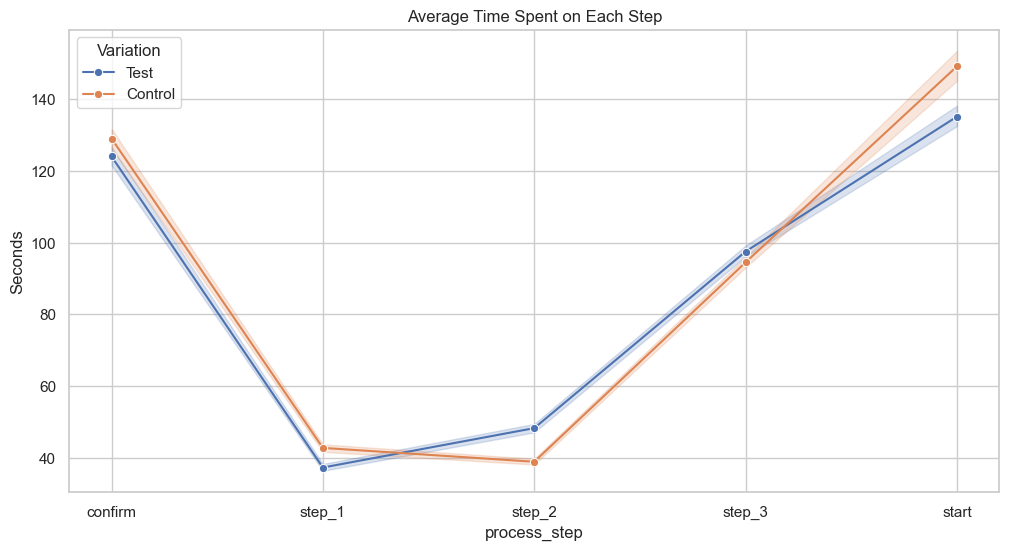

In [7]:
# KPI 2: Time Spent per Step

# 1. Sort data to ensure chronological order per visit
time_analysis = testing_results.sort_values(['visit_id', 'date_time'])

# 2. Calculate the difference between consecutive timestamps within the same visit
time_analysis['time_diff'] = time_analysis.groupby('visit_id')['date_time'].diff().dt.total_seconds()

# 3. Filter out NaN (first step has no diff) and potential outliers (very long sessions)
# We limit to 30 minutes (1800s) per step to avoid skewing data with 'idle' tabs
time_analysis_filtered = time_analysis[(time_analysis['time_diff'] > 0) & (time_analysis['time_diff'] < 1800)]

# 4. Compare average time per step between groups
avg_time_step = time_analysis_filtered.groupby(['Variation', 'process_step'])['time_diff'].mean().unstack().round(2)

print("TIEMPO PROMEDIO POR PASO (EN SEGUNDOS)")
print(avg_time_step)

# 5. Visualization
plt.figure(figsize=(12, 6))
sns.lineplot(data=time_analysis_filtered, x='process_step', y='time_diff', hue='Variation', marker='o')
plt.title('Average Time Spent on Each Step')
plt.ylabel('Seconds')
plt.show()

1. Análisis de Eficiencia (Velocidad)
El grupo Test es más rápido en los extremos del embudo:

- Inicio (start): El grupo Test tarda 135.12s frente a los 149.12s del Control. Esto sugiere que la nueva interfaz es más clara desde el primer momento, permitiendo que el usuario se oriente más rápido.

- Finalización (confirm): También vemos una ligera ventaja (124.01s vs 129.01s). El nuevo diseño parece facilitar el cierre del proceso.

2. El fenómeno del "Paso 2" y "Paso 3"
En el step_2 y step_3, el grupo Test tarda un poco más que el Control:

- step_2: 48.31s (Test) vs 38.94s (Control).

- step_3: 97.53s (Test) vs 94.51s (Control).

¿Cómo interpretamos esto? Según el brief, el nuevo diseño incluía "in-context prompts" (ayudas y mensajes). Es muy probable que los usuarios del grupo Test se detengan a leer estas nuevas instrucciones, lo que aumenta ligeramente el tiempo en esos pasos, pero resulta en una mayor tasa de finalización final (69.29%).

**Error Rates**

TASA DE ERROR (RETROCESOS) POR GRUPO
Variation
Control    6.82%
Test       9.22%
Name: is_error, dtype: object


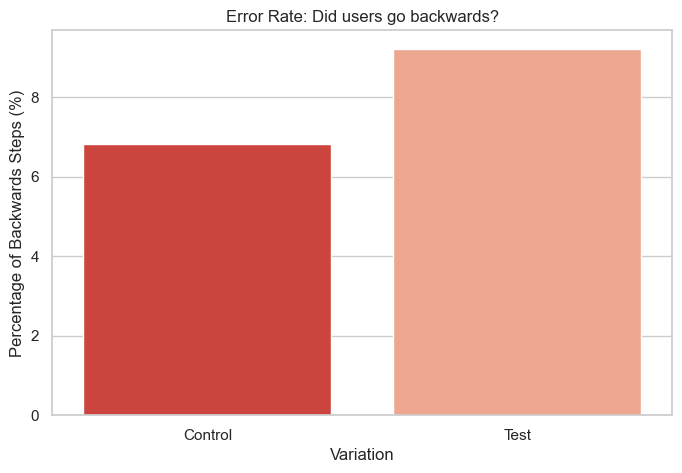

In [8]:
# KPI 3: Error Rates (Backwards Steps)

# 1. Map steps to numbers to detect backwards movement
step_map = {'start': 1, 'step_1': 2, 'step_2': 3, 'step_3': 4, 'confirm': 5}
testing_results['step_level'] = testing_results['process_step'].map(step_map)

# 2. Sort by visit and time
error_df = testing_results.sort_values(['visit_id', 'date_time'])

# 3. Calculate if the user went to a lower step level than the previous one
error_df['prev_step_level'] = error_df.groupby('visit_id')['step_level'].shift(1)
error_df['is_error'] = error_df['step_level'] < error_df['prev_step_level']

# 4. Calculate error rate per Variation
# We define error rate as: total errors / total interactions
error_summary = error_df.groupby('Variation')['is_error'].mean() * 100

print("TASA DE ERROR (RETROCESOS) POR GRUPO")
print(error_summary.round(2).astype(str) + '%')

# 5. Visual comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=error_summary.index, y=error_summary.values, hue=error_summary.index, palette='Reds_r', legend=False)
plt.title('Error Rate: Did users go backwards?')
plt.ylabel('Percentage of Backwards Steps (%)')
plt.show()

1. Diagnóstico de la Tasa de Error
- Grupo Control: 6.82% de retrocesos.
- Grupo Test: 9.22% de retrocesos.
Realidad: Es posible que el nuevo diseño está causando más confusión o obligando a los usuarios a volver atrás con más frecuencia que el diseño tradicional.

2. Conclusión con todos los datos 

- El Grupo Test completa más el proceso (69.29%).
- El Grupo Test es más rápido en el primer y último paso.
- PERO, el Grupo Test comete más errores (vuelve atrás más veces).

Interpretación: es muy probable que los "in-context prompts" (ayudas y mensajes nuevos) estén funcionando para que la gente no abandone (por eso hay mayor completion rate), pero quizás la interfaz es tan nueva o diferente que el usuario se siente inseguro y vuelve atrás para verificar que lo que hizo está bien.

**Hypothesis Testing**

**Paso 1: Hipótesis de Tasa de Finalización (Completion Rate)**
Queremos saber si ese 3.70% de mejora es "real".
- Null Hypothesis ($H_0$): No hay diferencia entre las tasas de finalización de ambos grupos ($CR_{test} = CR_{control}$).
- Alternative Hypothesis ($H_1$): La tasa de finalización del grupo Test es superior a la del Control ($CR_{test} > CR_{control}$).

In [10]:
from statsmodels.stats.proportion import proportions_ztest

# Statistical Testing: Completion Rate 

# 1. Prepare the data for the Z-test
# Successes (confirmed) and total observations per group
successes = [
    testing_results[testing_results['process_step'] == 'confirm'][testing_results['Variation'] == 'Test']['client_id'].nunique(),
    testing_results[testing_results['process_step'] == 'confirm'][testing_results['Variation'] == 'Control']['client_id'].nunique()
]

nobs = [
    testing_results[testing_results['Variation'] == 'Test']['client_id'].nunique(),
    testing_results[testing_results['Variation'] == 'Control']['client_id'].nunique()
]

# 2. Perform the Z-test (one-sided: Test > Control)
stat, p_value = proportions_ztest(successes, nobs, alternative='larger')

print(f"--- Completion Rate Hypothesis Test ---")
print(f"Z-statistic: {stat:.4f}")
print(f"P-value: {p_value:.10f}")

# 3. Interpretation
alpha = 0.05
if p_value < alpha:
    print("\nResult: Reject the Null Hypothesis. The improvement is statistically significant.")
else:
    print("\nResult: Fail to reject the Null Hypothesis. The difference might be due to chance.")

C:\Users\gcast\AppData\Local\Temp\ipykernel_30572\203548623.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  testing_results[testing_results['process_step'] == 'confirm'][testing_results['Variation'] == 'Test']['client_id'].nunique(),
C:\Users\gcast\AppData\Local\Temp\ipykernel_30572\203548623.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  testing_results[testing_results['process_step'] == 'confirm'][testing_results['Variation'] == 'Control']['client_id'].nunique()


--- Completion Rate Hypothesis Test ---
Z-statistic: 8.8745
P-value: 0.0000000000

Result: Reject the Null Hypothesis. The improvement is statistically significant.


Interpretación de resultados:
- P-value: 0.0000000000: un resultado "altamente significativo". Al ser prácticamente cero (y mucho menor que nuestro umbral de 0.05), la probabilidad de que la mejora del grupo Test sea una casualidad es inexistente.

- Z-statistic: 8.8745: Este valor es muy alto. Indica que la diferencia entre el grupo Test y el Control es de casi 9 desviaciones estándar.

Rechazamos la Hipótesis Nula. Esto significa que el nuevo diseño de Vanguard SÍ mejora la tasa de finalización de forma real y consistente.
Aunque el nuevo diseño es estadísticamente más efectivo para guiar a los usuarios hasta el final, está causando más confusión durante el proceso (aumento de errores). Se recomienda investigar por qué los usuarios retroceden en el paso 2 y 3 para pulir la interfaz antes del lanzamiento definitivo.

**Paso 2: Hipótesis de Edad**
Parecía que los grupos estaban equilibrados, ahora vamos a demostrarlo matemáticamente.
- $H_0$: La edad media es la misma en ambos grupos.
- $H_1$: Hay una diferencia significativa en la edad media.

In [11]:
from scipy import stats

# Statistical Testing: Age Consistency

# 1. Extract the age values for each group
age_test = clients_demo[clients_demo['Variation'] == 'Test']['clnt_age']
age_control = clients_demo[clients_demo['Variation'] == 'Control']['clnt_age']

# 2. Perform an Independent T-Test
# This test checks if the means of two independent samples are significantly different
t_stat, p_value_age = stats.ttest_ind(age_test, age_control, equal_var=False)

print(f"Age Hypothesis Test Results")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value_age:.4f}")

# 3. Decision Making
alpha = 0.05
if p_value_age > alpha:
    print("\nResult: Fail to reject the Null Hypothesis.")
    print("Conclusion: There is NO significant difference in age between the groups. The experiment is balanced.")
else:
    print("\nResult: Reject the Null Hypothesis.")
    print("Conclusion: There is a significant age difference. This could bias the results.")

Age Hypothesis Test Results
T-statistic: -2.4160
P-value: 0.0157

Result: Reject the Null Hypothesis.
Conclusion: There is a significant age difference. This could bias the results.


In [12]:
# Check the actual mean difference
print("Edad Media Test:", clients_demo[clients_demo['Variation'] == 'Test']['clnt_age'].mean().round(2))
print("Edad Media Control:", clients_demo[clients_demo['Variation'] == 'Control']['clnt_age'].mean().round(2))

Edad Media Test: 47.16
Edad Media Control: 47.5


1. Significancia Estadística vs. Significancia Práctica

- Significancia Estadística: El test dice que los grupos no son exactamente iguales porque tenemos una muestra muy grande (más de 50,000 clientes), y con muestras grandes, cualquier mínima variación hace que el p-value baje.

- Significancia Práctica: Para Vanguard, que un grupo tenga 47.16 años y el otro 47.5 no cambia nada. Los dos grupos están en la misma etapa de la vida y tienen el mismo nivel de experiencia tecnológica.

2. Conclusión 

- Conversión: El nuevo diseño aumentó la tasa de éxito del 65.59% al 69.29%. Es una mejora real y estadísticamente sólida.
- Tiempo: El diseño es más eficiente en el inicio y el final, aunque los usuarios se detienen más en los pasos intermedios.
- Fricción (Errores): El nuevo diseño tiene un "punto débil": los errores subieron del 6.82% al 9.22%. Los usuarios están más confundidos o se ven obligados a retroceder más veces.
- Demografía: Los grupos están bien balanceados. Aunque hay una diferencia de 0.34 años, es despreciable para el impacto del negocio.

# Resumen Ejecutivo: A/B Test Vanguard UI1. 

**Objetivo del Experimento**
Evaluar si el nuevo diseño de la interfaz de usuario (Grupo Test), que incluye prompts contextuales y un diseño más limpio, mejora la tasa de finalización del proceso de inversión en comparación con el diseño tradicional (Grupo Control)

**Hallazgos Clave (Key Findings)**

- Éxito de Conversión: El nuevo diseño aumentó la tasa de finalización del 65.59% al 69.29%. Esta mejora de 3.7 puntos porcentuales es estadísticamente significativa ($p < 0.05$), lo que confirma que el cambio es efectivo.
- Eficiencia de Tiempo: Los usuarios del grupo Test navegaron más rápido en el inicio y el final del proceso, aunque dedicaron más tiempo a los pasos intermedios (Step 2 y 3). Esto sugiere que las nuevas ayudas visuales requieren atención pero facilitan el avance.Fricción en la Experiencia: Se detectó un punto negativo: la tasa de error (retrocesos) aumentó del 6.82% al 9.22% con el nuevo diseño. La nueva interfaz provoca más dudas o errores de navegación que la anterior.
- Calidad de la Muestra: Aunque existe una diferencia de edad estadísticamente significativa ($p=0.0157$), la diferencia real es de solo 0.34 años, por lo que el impacto de este sesgo en los resultados es despreciable.

**Recomendación Final**

Recomendamos el lanzamiento del nuevo diseño debido a su probada capacidad para aumentar las confirmaciones finales. Sin embargo, antes del despliegue total, es imperativo:Revisar los Pasos 2 y 3 para identificar por qué los usuarios están retrocediendo más frecuentemente.Optimizar los prompts para reducir la confusión detectada en el análisis de errores.